# Tutorial: ERA5 reanalysis data
Author: Daniel Steinfeld (University of Bern) & Ophélia Miralles (EPFL)

## ECMWF Reanalysis v5 (ERA5)

ERA5 is the fifth generation atmospheric reanalysis of the global climate covering the period from January 1950 to present. ERA5 is produced by the Copernicus Climate Change Service (C3S) at European Centre for Medium-Range Weather Forecasts (ECMWF). ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. The data cover the Earth on a 30km grid and resolve the atmosphere using 137 levels from the surface up to a height of 80km.  

Learn more about ERA5 from [here](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5).

## Setup

Make sure you have the required packages (for details see environment.yml):

- [xarray](http://xarray.pydata.org/en/stable/) # reading gridded multidimensional data (for example NetCDF format)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) # plotting on map
- [cdsapi](https://pypi.org/project/cdsapi/) # retreaving data from Copernicus Climate Data Store (only for demonstration, we have all the data already stored locally)

Prepare the conda environment:

```bash
    conda create -y -q -n downscale_dev
    conda env update -q -f environment.yml -n downscale_dev
    conda activate downscale_dev
```

In [92]:
# =======
# import packages

# for data
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
#import pandas as pd

import logging
logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# copernicus climate data store: See https://cds.climate.copernicus.eu/api-how-to
try:
    import cdsapi
except:
    logger.warning("cdsapi is not installed. Please follow the instructions on <https://cds.climate.copernicus.eu/api-how-to>")

# for plotting
try:
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature;
    %matplotlib inline
except:
    logger.warning("Matplotlib and/or Cartopy is not installed in your python environment. Xarray Dataset plotting functions will not work.")

## 1. Retrieve ERA5 reanalysis

ERA5 data is freely available to everyone from the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&text=ERA5). Follow the instructions [here](https://cds.climate.copernicus.eu/api-how-to) for registration and installation of the python package "cdsapi".  

Here, we download 6 days of surface data during winterstorm Ciara (Sabine in Germany) in February 2020: https://en.wikipedia.org/wiki/Storm_Ciara.

- from 8 - 13 February 2020 (parameter 'day')
- only over Europe (parameter 'area')
- only every 6 hours (parameter 'time' 
- (otherwise file becomes large)

In [2]:
# create data folder
from pathlib import Path
Path("../data/ERA5").mkdir(parents=True, exist_ok=True)

# checking if files already exists, else download ERA5 data
my_file = Path("../data/ERA5/ERA5_surface_Feb2020.nc")
if my_file.is_file():
    print("ERA5 file already exists!")
else:
    c = cdsapi.Client()

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature',
                'mean_sea_level_pressure', 'total_precipitation',
            ],
            'year': '2020',
            'month': '02',
            'day': [
                '08', '09', '10',
                '11', '12', '13',
            ],
            'time': [
                '00:00', '06:00', '12:00',
                '18:00',
            ],
            'area': [
                80, -30, 30,
                60,
            ],
        },
        '../data/ERA5/ERA5_surface_Feb2020.nc')

ERA5 file already exists!


## Read ERA5 reanalysis with xarray

ERA5 reanalysis, and many other weather and climate data sets, are stored as netCDF files (.nc). [What is netCDF?](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#ncFAQGeneral)  
[Xarray](http://xarray.pydata.org/en/stable/index.html) makes working with labelled multi-dimensional NumPy-arrays simple, is inspired by pandas, and is particularly tailored to working with netCDF files.

In [3]:
from IPython.display import Image
Image(url='http://xarray.pydata.org/en/stable/_images/dataset-diagram.png', width = 600)

In [4]:
# load ERA5 data
ds = xr.open_dataset('data/ERA5/ERA5_surface_Feb2020.nc')
print(type(ds))
ds

<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:    (latitude: 201, longitude: 361, time: 24)
Coordinates:
  * longitude  (longitude) float32 -30.0 -29.75 -29.5 -29.25 ... 59.5 59.75 60.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2020-02-08 ... 2020-02-13T18:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-27 13:51:25 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

A dataset can hold multiple data variables. Here, the dataset has variables called `u10`, `v10`,`t2m`,`msl`, and `tp`. These variables are stored as DataArray with 
* `dimensions`: time, lat, lon
* `coordinates`: labels of each point in the form of a Python-dictionary
* `attributes`: Metadata

In [5]:
# Example for t2m = 2 meter temperature
print(type(ds.t2m))
ds.t2m.attrs

<class 'xarray.core.dataarray.DataArray'>


{'units': 'K', 'long_name': '2 metre temperature'}

In [6]:
# let's get the raw NumPy-like multidimensional arrays
print(type(ds.t2m.data))
print(ds.t2m.data.shape) # time, latitude, longitude
ds.t2m.data

<class 'numpy.ndarray'>
(24, 201, 361)


array([[[244.6225 , 245.16193, 245.59563, ..., 250.94667, 251.00314,
         251.3924 ],
        [245.03458, 245.49352, 245.95125, ..., 251.04639, 250.98392,
         250.92384],
        [245.3926 , 245.77704, 246.16028, ..., 250.85536, 250.88058,
         250.90582],
        ...,
        [292.57764, 292.58124, 292.56082, ..., 284.01163, 280.8844 ,
         278.3086 ],
        [292.59686, 292.5464 , 292.51157, ..., 285.344  , 281.39258,
         277.58414],
        [292.5548 , 292.49835, 292.4611 , ..., 285.73807, 282.1555 ,
         277.87247]],

       [[242.52365, 243.22647, 243.82236, ..., 250.64632, 250.73642,
         251.1485 ],
        [242.33382, 242.95735, 243.58208, ..., 250.77727, 250.75565,
         250.73282],
        [242.17163, 242.68944, 243.20844, ..., 250.56822, 250.6211 ,
         250.67395],
        ...,
        [292.4623 , 292.48273, 292.5428 , ..., 295.59796, 293.10144,
         290.08353],
        [292.50916, 292.53558, 292.57162, ..., 295.53308, 293.38858,
   

### Let's do some plots to get familiar with the data

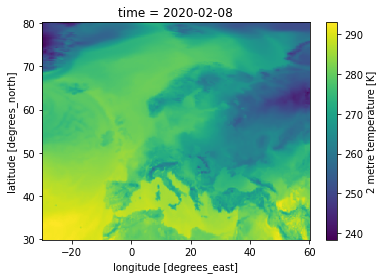

In [7]:
# plot 2 meter temperature at time step = 0
ds.t2m.isel(time=0).plot()
plt.show()
# indexing works also like this: 
# ds.t2m[0,:,:] # gives the time=0, latitude=:, longitude=: position respectively
# ds.t2m.sel(time='2020-02-05 00:00') 

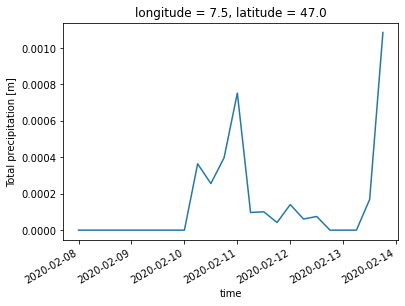

In [8]:
# time series plot of precipitation for Bern
ds.tp.sel(latitude=46.9, longitude=7.4, method='nearest').plot()
plt.show()
# two peaks are fronts

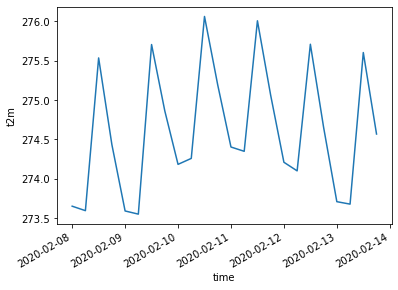

In [9]:
# plot temporal evolution of mean 2m temperature (averaged over entire domain at each time step)
ds.t2m.mean(dim=('longitude', 'latitude')).plot()
plt.show()

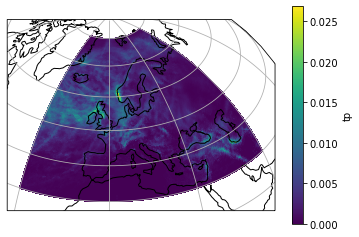

In [10]:
# more advanced plotting with cartopy
# Have a look at all existing projections: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

# plot accumulated (over 6 days) precipitation on a map
ax = plt.axes(projection=ccrs.Orthographic(0, 35))
ds.tp.sum(dim=('time')).plot(ax=ax,transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
#ax.set_extent([-30, 60, 30, 80])
#ax.set_global()
plt.show()

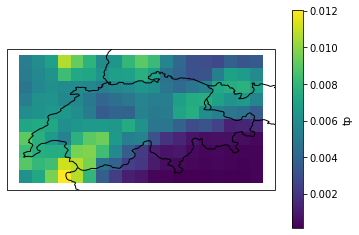

In [11]:
# same plot but only over Switzerland (and with different projection)
ax = plt.axes(projection=ccrs.PlateCarree())
ds.tp.sel(latitude=slice(48,45.7), longitude=slice(5.9,10.5)).sum(dim=('time')).plot(ax=ax,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
plt.show()

In [12]:
# plot wind speed as animation: This nicely illustrates the spatial and temporal evolution of wind

# calc wind speed (m/s) and store it as xarray data
import xarray.ufuncs as xu
windspeed = xu.sqrt(ds.u10**2+ds.v10**2)
# you can do all calculations with numpy functions
# windspeed = np.sqrt(ds.u10**2+ds.v10**2)

from matplotlib import animation
from IPython.display import HTML, display

fig, ax = plt.subplots(figsize=(10,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
# Plot the initial frame. 
cax = windspeed[0,:,:].plot(
    add_colorbar=True,
    vmin=windspeed.min(), vmax=windspeed.max(),
    cbar_kwargs={
        'extend':'neither',
        'label':'wind speed [m/s]'
    }
)

# Next we need to create a function that updates the values, as well as the title.
def animate(frame):
    cax.set_array(windspeed[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(windspeed.coords['time'].values[frame])[:13])
    ax.coastlines()
    ax.set_extent([-30, 60, 30, 77])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,            
    animate,         
    frames=24,      
    interval=200     
)

plt.close()

In [13]:
HTML(ani.to_jshtml())

### Math operations with xarray

Arithmetic operations automatically vectorize (like numpy) over all array values.   
See more examples here: http://xarray.pydata.org/en/stable/computation.html

In [14]:
# Calculate standardized/normalized anomalies (here, clim and std is calculated over the short period of 6 days...probably a bit short :))
def calculate_anomaly(ds):   
    clim = ds.mean(dim="time")
    std = ds.std(dim="time")
    return (ds - clim) / std

ds_normalized_anom = calculate_anomaly(ds) # apply function on entire Dataset (and all variables) --> output is again a Dataset
t2m_normalized_anom = calculate_anomaly(ds.t2m) # apply function on DataArray t2m --> output is a DataArray
t2m_normalized_anom_only_data = calculate_anomaly(ds.t2m).data# --> output is a NumPy array

# we could to the same with numpy functions
def calculate_anomaly_numpy(ds):   
    clim = np.mean(ds,axis=0)
    std = np.std(ds,axis=0)
    return (ds - clim) / std

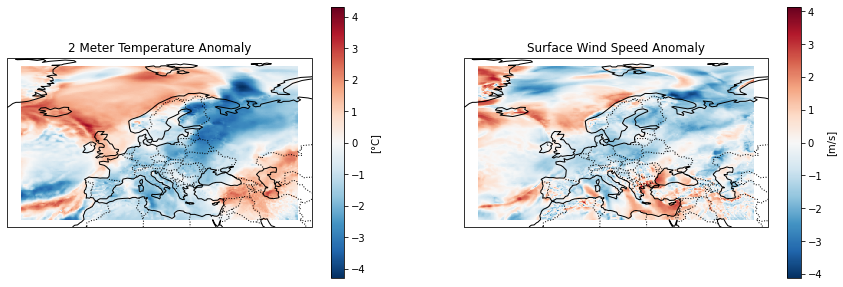

In [15]:
# Example plotting

# select timestep for plotting
timestep = 0
# at timestep = 0 we can see the cold front of a cyclone over the Atlantic

fig, axes = plt.subplots(1,2,figsize=(15, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# left
fig1 = calculate_anomaly(ds.t2m).isel(time=timestep).plot(ax=axes[0], transform=ccrs.PlateCarree())
axes[0].set_title('2 Meter Temperature Anomaly')
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS, linestyle=':')
fig1_cbar = fig1.colorbar
fig1_cbar.ax.set_ylabel('[°C]')

# right
fig2 = calculate_anomaly(np.sqrt(ds.u10**2+ds.v10**2)).isel(time=timestep).plot(ax=axes[1], transform=ccrs.PlateCarree())
axes[1].set_title('Surface Wind Speed Anomaly')
axes[1].coastlines()
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
fig2_cbar = fig2.colorbar
fig2_cbar.ax.set_ylabel('[m/s]')

plt.show()

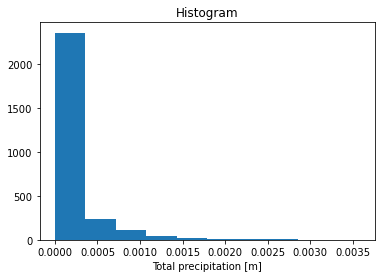

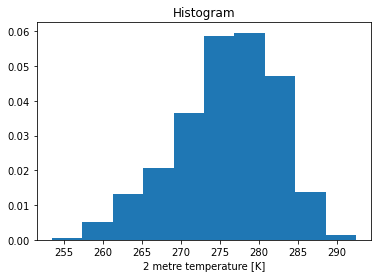

In [16]:
# historgram / probability density of cells located "over" Switzerland, with boundingbox = [45.817995, 47.8084648, 5.9559113, 10.4922941]
ds.tp.sel(latitude=slice(48,45), longitude=slice(5,11)).plot.hist(density=True)
plt.show()
# rain is non-normal distributed

ds.t2m.sel(latitude=slice(48,45), longitude=slice(5,11)).plot.hist(density=True)
plt.show()
# temperature is usually normally distributed

## A quick look at the ERA5 topography

In [4]:
# load ERA5 topography
ds_topo = xr.open_dataset('../data/ERA5/topo.nc')

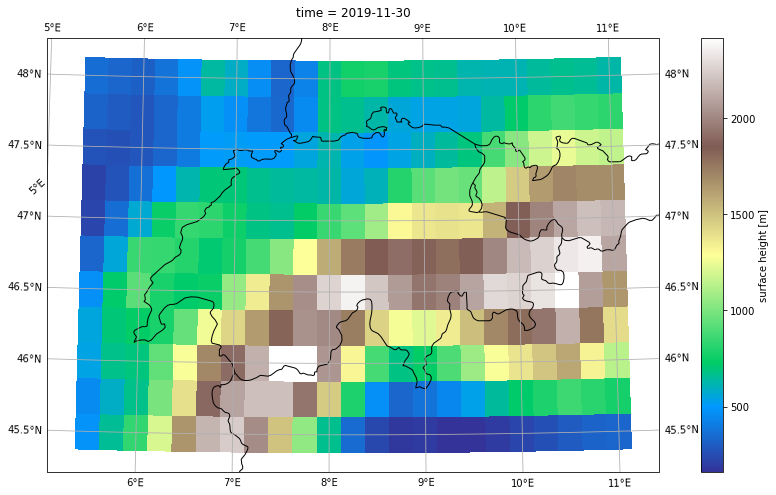

In [13]:
# plot over Switzerland
# the resolution is rather low...

plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.AlbersEqualArea(8.222665776, 46.800663464))
ds_topo.height.sel(lat=slice(45.46,48.15), lon=slice(5.27,11.02)).plot(ax=ax, cmap='terrain', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.gridlines(draw_labels=True)
#plt.savefig('../docs/figures/topo_ERA5.png', dpi=200)

In [19]:
# let's have a look at the spatial (lat/lon) and temporal (time) resolution of ERA5

delta_time = np.unique((
                    ds['time'].to_index()[1:] - 
                    ds['time'].to_index()[:-1])
                    .astype('timedelta64[h]')
            )

delta_lat = abs(np.unique((
                ds['latitude'].data[1:] - 
                ds['latitude'].data[:-1])
            ))
delta_lon = abs(np.unique((
                ds['longitude'].data[1:] - 
                ds['longitude'].data[:-1])
            ))
print('temporal resolution is (in hours): ', delta_time) # for this tutorial we downloaded data every 6 hours, but ERA5 has hourly data
print('spatial resolution latitude (in degree): ', delta_lat)
print('spatial resolution longitude (in degree): ', delta_lon)
print('0.25° is roughly 31 kilometer')
print('COMSO-1 has a spatial resolution of 0.11° (~1.1 km). This will be our target :)')

temporal resolution is (in hours):  [6]
spatial resolution latitude (in degree):  [0.25]
spatial resolution longitude (in degree):  [0.25]
0.25° is roughly 31 kilometer
COMSO-1 has a spatial resolution of 0.11° (~1.1 km). This will be our target :)


## Further reading

- xarray tutorials: https://xarray-contrib.github.io/xarray-tutorial/index.html
- Applying unvectorized functions with apply_ufunc: https://xarray.pydata.org/en/stable/examples/apply_ufunc_vectorize_1d.html
- using xarray with tensorflow (for weather prediction): https://github.com/pangeo-data/WeatherBench. The Notebooks could be used as a template? 
